In [1]:
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from typing import Tuple
from datetime import datetime as dt

import random 
import torch.optim as optim
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


/home/luizp/projects/pibit/pibit/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1701
EPOCHS = 20
MODEL_REPO = "/home/luizp/projects/pibit/src/cleaner/cicClean.csv"
BATCH_SIZE = 512
LEARNING_RATE = 1e-3

In [3]:
class ToImage:
    def __call__(self, array: torch.Tensor, keep_normalization=True):
        """ The idea is to convert a 1d array to a 2d array by resizing (with padding) to the square root of the 1d shape

        Ex: 
            - shape: 2048  
            - sqrt(shape) = 45.25 -> round to ceil (46)
            - resize the feature vector to 46x46 
            - return the new feature vector as a RGB PIL Image for torchvision transforms
         """
        #feat = array.shape[0]
        feat = array.shape[0]
        n = int(np.ceil(feat ** 0.5))

        array = array.cpu().numpy().copy()
        
        # Squared size with padding
        array.resize((n, n))
        if not keep_normalization:
            return (array * 255).astype(np.uint8)

        return torch.Tensor(array.astype(np.float32)).unsqueeze(0)

In [4]:
class CustomDataset(Dataset):
    """ Custom dataset class used for applying transforms to the features. """
    def __init__(self, subset: Tuple[torch.Tensor, torch.Tensor], transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[0][index], self.subset[1][index]
    
        if self.transform:
            x = self.transform(x)

        return x, y
        
    def __len__(self):
        return self.subset[0].size(0)

In [5]:
def validate(device: str, epoch: int, loss_fn, MODEL, dataset: DataLoader):
    # Validation
    MODEL.eval()
    it_eval = tqdm(enumerate(dataset), total=len(dataset))
    running_loss = 0.
    correct = 0
    qt = 1
    metrics = dict(tp=0, tn=0, fp=0, fn=0)
    y_pred = list()
    y_true = list()
    with torch.no_grad():
        for _, (x, y) in it_eval:
            x = x.to(device)
            y = y.to(device)

            output = MODEL(x)
            running_loss += loss_fn(output, y).item()
            y_pred.extend(torch.argmax(output, 1).cpu().numpy())
            y_true.extend(y.data.cpu().numpy())
            correct += torch.sum(torch.argmax(output, 1).eq(y)).item()
            qt += len(x)
            desc = f"[{now()}] Epoch {str(epoch).zfill(3)} Val. Acc: {correct/qt:.4f} Val. Loss: {running_loss / len(dataset):.8f}"
            it_eval.set_description(desc)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics["tp"] = tp
    metrics["fp"] = fp
    metrics["tn"] = tn
    metrics["fn"] = fn
    return running_loss / len(dataset), correct/qt, metrics

In [6]:
def now():
    return dt.now().strftime("%d-%m-%Y %H-%M-%S")

In [7]:
def train(device: str, epoch: int, optimizer, loss_fn, MODEL, dataset: DataLoader):
    # Put the MODEL in the training mode
    MODEL.train()
    running_loss = 0.
    qt = 1
    correct = 0

    # Just add a fancy progress bar to the terminal...
    it = tqdm(enumerate(dataset), total=len(dataset))

    for _, (x, y) in it:
        x = x.to(device)
        y = y.to(device)
        
        # Make predictions for this batch
        outputs = MODEL(x)

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        loss = loss_fn(outputs, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        correct += torch.sum(torch.argmax(outputs, 1).eq(y)).item()
        qt += len(x)
    
        # Gather data and report
        running_loss += loss.item()

        desc = f"[{now()}] Epoch {str(epoch).zfill(3)} Acc: {correct/qt:.4f} Loss: {running_loss / len(dataset):.8f}"
        it.set_description(desc)
    
    # Loss / Accuracy
    return running_loss / len(dataset), correct/qt

In [8]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=2):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1, 128, kernel_size=7, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=1, stride=2),
        nn.Conv2d(128, 128, kernel_size=1, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(128, 128, kernel_size=2, padding=1),
        nn.ReLU(inplace=True),            
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),            
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
        
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.Linear(4608, 128),
      nn.ReLU(inplace=True),            
      nn.Dropout(),
      nn.Linear(128, 128),
      nn.ReLU(inplace=True),            
      nn.Linear(128, num_classes)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [9]:
torch.cuda.is_available()

True

In [10]:
allmetrics = []

In [11]:
def no_update():
    # Reproducibility
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)

    MODEL = AlexNet().to('cuda')

    #if MODEL is None or not isinstance(nn.Module):
    #    raise TypeError("The model does not exist or isn't an instance of nn.Module (PyTorch)")
    
    transform = transforms.Compose([
        ToImage(),
    ])
    csv_path = "/home/luizp/projects/pibit/src/cleaner/cicClean.csv"
    df = pd.read_csv(csv_path)
    y = df.iloc[:, -1].values
    x = df.iloc[:, :-1].values
    y = y[::-1]
    x = np.squeeze(x)
    #x = x.reshape((1, -1))
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.1, random_state=42
    )

    #raise Exception("Precisa carregar e separar (treino, validação e teste) um dataset qualquer para executar")
    x_train = torch.Tensor(x_train)
    y_train = torch.LongTensor(y_train)
    x_test  = torch.Tensor(x_test)
    y_test  = torch.LongTensor(y_test)
    #x_val   = torch.Tensor(x_val)
    #y_val   = torch.LongTensor(y_val)

    # A parte de fazer o reshape está quando passo uma transformada (ToImage()) como parâmetro
    cd_train = CustomDataset(subset=(x_train, y_train), transform=transform)
    cd_test  = CustomDataset(subset=(x_test, y_test), transform=transform)
    #cd_val   = CustomDataset(subset=(X_val, y_val), transform=transform)

    data_train = DataLoader(cd_train, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)
    data_test  = DataLoader(cd_test, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)
    #data_val   = DataLoader(cd_val, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)

    loss_fn   = nn.CrossEntropyLoss()
    optimizer = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train(device, epoch, optimizer, loss_fn, MODEL, data_train)
        #val_loss, val_acc, _ = validate(device, epoch, optimizer, loss_fn, MODEL, data_val)

        _, _, metrics = validate(device, epoch, loss_fn, MODEL, data_test)
        allmetrics.append(metrics)
        print(metrics)


In [12]:
if __name__ == "__main__":
    no_update()
    print("Finished experiment!")

cuda


[07-02-2024 11-17-45] Epoch 001 Acc: 0.9842 Loss: 0.04786848: 100%|██████████| 1758/1758 [01:59<00:00, 14.68it/s]
[07-02-2024 11-17-50] Epoch 001 Val. Acc: 0.9960 Val. Loss: 0.02406098: 100%|██████████| 196/196 [00:05<00:00, 38.42it/s]


{'tp': 49753, 'tn': 49851, 'fp': 200, 'fn': 196}


[07-02-2024 11-19-58] Epoch 002 Acc: 0.9890 Loss: 0.03973140: 100%|██████████| 1758/1758 [02:07<00:00, 13.80it/s]
[07-02-2024 11-20-04] Epoch 002 Val. Acc: 0.9968 Val. Loss: 0.01817494: 100%|██████████| 196/196 [00:05<00:00, 36.23it/s]


{'tp': 49754, 'tn': 49925, 'fp': 126, 'fn': 195}


[07-02-2024 11-22-18] Epoch 003 Acc: 0.9960 Loss: 0.01782115: 100%|██████████| 1758/1758 [02:13<00:00, 13.12it/s]
[07-02-2024 11-22-24] Epoch 003 Val. Acc: 0.9820 Val. Loss: 0.06343427: 100%|██████████| 196/196 [00:05<00:00, 35.39it/s]


{'tp': 49855, 'tn': 48349, 'fp': 1702, 'fn': 94}


[07-02-2024 11-24-24] Epoch 004 Acc: 0.9961 Loss: 0.01680872: 100%|██████████| 1758/1758 [01:59<00:00, 14.68it/s]
[07-02-2024 11-24-30] Epoch 004 Val. Acc: 0.9984 Val. Loss: 0.01124534: 100%|██████████| 196/196 [00:05<00:00, 35.61it/s]


{'tp': 49879, 'tn': 49961, 'fp': 90, 'fn': 70}


[07-02-2024 11-26-51] Epoch 005 Acc: 0.9946 Loss: 0.02214758: 100%|██████████| 1758/1758 [02:19<00:00, 12.56it/s]
[07-02-2024 11-26-56] Epoch 005 Val. Acc: 0.9963 Val. Loss: 0.01623868: 100%|██████████| 196/196 [00:05<00:00, 37.36it/s]


{'tp': 49702, 'tn': 49924, 'fp': 127, 'fn': 247}


[07-02-2024 11-29-31] Epoch 006 Acc: 0.9968 Loss: 0.01399305: 100%|██████████| 1758/1758 [02:34<00:00, 11.41it/s]
[07-02-2024 11-29-38] Epoch 006 Val. Acc: 0.9981 Val. Loss: 0.01340095: 100%|██████████| 196/196 [00:06<00:00, 28.02it/s]


{'tp': 49882, 'tn': 49928, 'fp': 123, 'fn': 67}


[07-02-2024 11-32-23] Epoch 007 Acc: 0.9971 Loss: 0.01331461: 100%|██████████| 1758/1758 [02:44<00:00, 10.71it/s]
[07-02-2024 11-32-37] Epoch 007 Val. Acc: 0.9975 Val. Loss: 0.01040802: 100%|██████████| 196/196 [00:13<00:00, 14.13it/s]


{'tp': 49839, 'tn': 49915, 'fp': 136, 'fn': 110}


[07-02-2024 11-35-25] Epoch 008 Acc: 0.9979 Loss: 0.00975420: 100%|██████████| 1758/1758 [02:47<00:00, 10.50it/s]
[07-02-2024 11-35-35] Epoch 008 Val. Acc: 0.9986 Val. Loss: 0.00828298: 100%|██████████| 196/196 [00:09<00:00, 19.65it/s]


{'tp': 49907, 'tn': 49956, 'fp': 95, 'fn': 42}


[07-02-2024 11-38-45] Epoch 009 Acc: 0.9981 Loss: 0.00840577: 100%|██████████| 1758/1758 [03:10<00:00,  9.25it/s]
[07-02-2024 11-38-51] Epoch 009 Val. Acc: 0.9984 Val. Loss: 0.00828119: 100%|██████████| 196/196 [00:05<00:00, 35.89it/s]


{'tp': 49901, 'tn': 49939, 'fp': 112, 'fn': 48}


[07-02-2024 11-42-03] Epoch 010 Acc: 0.9981 Loss: 0.00850859: 100%|██████████| 1758/1758 [03:10<00:00,  9.21it/s]
[07-02-2024 11-42-18] Epoch 010 Val. Acc: 0.9987 Val. Loss: 0.00728745: 100%|██████████| 196/196 [00:14<00:00, 13.31it/s]


{'tp': 49900, 'tn': 49966, 'fp': 85, 'fn': 49}


[07-02-2024 11-45-37] Epoch 011 Acc: 0.9980 Loss: 0.00931039: 100%|██████████| 1758/1758 [03:20<00:00,  8.77it/s]
[07-02-2024 11-45-54] Epoch 011 Val. Acc: 0.9982 Val. Loss: 0.01111952: 100%|██████████| 196/196 [00:10<00:00, 17.87it/s]


{'tp': 49903, 'tn': 49915, 'fp': 136, 'fn': 46}


[07-02-2024 11-49-18] Epoch 012 Acc: 0.9980 Loss: 0.00936761: 100%|██████████| 1758/1758 [03:23<00:00,  8.66it/s]
[07-02-2024 11-49-29] Epoch 012 Val. Acc: 0.9986 Val. Loss: 0.01364710: 100%|██████████| 196/196 [00:11<00:00, 16.67it/s]


{'tp': 49906, 'tn': 49956, 'fp': 95, 'fn': 43}


[07-02-2024 11-53-00] Epoch 013 Acc: 0.9986 Loss: 0.00655718: 100%|██████████| 1758/1758 [03:27<00:00,  8.46it/s]
[07-02-2024 11-53-06] Epoch 013 Val. Acc: 0.9987 Val. Loss: 0.00653410: 100%|██████████| 196/196 [00:05<00:00, 38.35it/s]


{'tp': 49918, 'tn': 49949, 'fp': 102, 'fn': 31}


[07-02-2024 11-56-38] Epoch 014 Acc: 0.9982 Loss: 0.00797119: 100%|██████████| 1758/1758 [03:32<00:00,  8.29it/s]
[07-02-2024 11-56-44] Epoch 014 Val. Acc: 0.9989 Val. Loss: 0.00769048: 100%|██████████| 196/196 [00:05<00:00, 35.28it/s]


{'tp': 49909, 'tn': 49978, 'fp': 73, 'fn': 40}


[07-02-2024 12-00-05] Epoch 015 Acc: 0.9979 Loss: 0.00919423: 100%|██████████| 1758/1758 [03:18<00:00,  8.87it/s]
[07-02-2024 12-00-22] Epoch 015 Val. Acc: 0.9988 Val. Loss: 0.00739692: 100%|██████████| 196/196 [00:17<00:00, 11.41it/s]


{'tp': 49899, 'tn': 49979, 'fp': 72, 'fn': 50}


[07-02-2024 12-03-36] Epoch 016 Acc: 0.9976 Loss: 0.00944935: 100%|██████████| 1758/1758 [03:11<00:00,  9.16it/s]
[07-02-2024 12-03-54] Epoch 016 Val. Acc: 0.9987 Val. Loss: 0.00603514: 100%|██████████| 196/196 [00:12<00:00, 15.29it/s]


{'tp': 49886, 'tn': 49981, 'fp': 70, 'fn': 63}


[07-02-2024 12-07-18] Epoch 017 Acc: 0.9985 Loss: 0.00729781: 100%|██████████| 1758/1758 [03:23<00:00,  8.62it/s]
[07-02-2024 12-07-24] Epoch 017 Val. Acc: 0.9985 Val. Loss: 0.00714136: 100%|██████████| 196/196 [00:05<00:00, 35.98it/s]


{'tp': 49922, 'tn': 49928, 'fp': 123, 'fn': 27}


[07-02-2024 12-10-47] Epoch 018 Acc: 0.9981 Loss: 0.00887574: 100%|██████████| 1758/1758 [03:23<00:00,  8.64it/s]
[07-02-2024 12-10-57] Epoch 018 Val. Acc: 0.9979 Val. Loss: 0.03375944: 100%|██████████| 196/196 [00:05<00:00, 35.44it/s]


{'tp': 49811, 'tn': 49983, 'fp': 68, 'fn': 138}


[07-02-2024 12-17-02] Epoch 019 Acc: 0.9986 Loss: 0.00596962: 100%|██████████| 1758/1758 [06:06<00:00,  4.80it/s]  
[07-02-2024 12-17-36] Epoch 019 Val. Acc: 0.9989 Val. Loss: 0.00685020: 100%|██████████| 196/196 [00:29<00:00,  6.67it/s]


{'tp': 49921, 'tn': 49973, 'fp': 78, 'fn': 28}


[07-02-2024 12-24-01] Epoch 020 Acc: 0.9986 Loss: 0.00623300: 100%|██████████| 1758/1758 [06:22<00:00,  4.59it/s]
[07-02-2024 12-24-30] Epoch 020 Val. Acc: 0.9987 Val. Loss: 0.00644219: 100%|██████████| 196/196 [00:26<00:00,  7.50it/s]


{'tp': 49914, 'tn': 49959, 'fp': 92, 'fn': 35}
Finished experiment!


In [12]:
from sklearn.metrics import roc_curve, auc


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [15]:
fpr = []
tpr = []
for i in allmetrics:
    fpr.append(i['fp']/(i['fp']+i['fn']))
    tpr.append(i['tp']/(i['tp']+i['tn']))

In [17]:
from sklearn.metrics import roc_curve, auc
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

ValueError: x is neither increasing nor decreasing : [0.50505051 0.39252336 0.94766147 0.5625     0.33957219 0.64736842
 0.55284553 0.69343066 0.7        0.63432836 0.74725275 0.6884058
 0.76691729 0.6460177  0.59016393 0.52631579 0.82       0.33009709
 0.73584906 0.72440945].

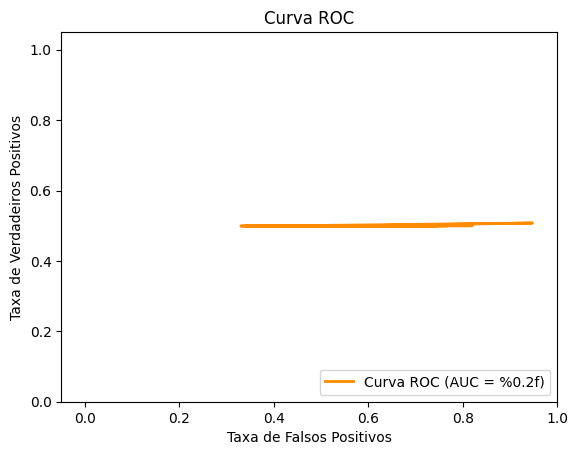

In [18]:
from sklearn.metrics import roc_curve, auc
#roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()